Combine all ages together

In [1]:
from HeaderP import *
from astropy import units as u
from astropy.coordinates import SkyCoord

In [82]:
galah_lb=pd.read_pickle('Data/galah_dr3_gaia_cm.pkl')
lamost_lb=pd.read_table('Data/LAMOST_dr6_v2_LRS.csv',delimiter='|')

galahages=pd.read_pickle('cannonages/galahages_cut.pkl')
lamostages=pd.read_pickle('cannonages/allLAMOST_cut.pkl')


apogeeages=pd.read_pickle('../SecondYear/CannonDR16_cut.pkl')
apogeeages['age']=apogeeages['Age']
apogeeages['l']=apogeeages['GLON']
apogeeages['b']=apogeeages['GLAT']
apogeeages['feh']=apogeeages['M_H']
apogeeages['teff']=apogeeages['TEFF']
apogeeages['logg']=apogeeages['LOGG']
apogeeages['mg_fe']=apogeeages['MG_FE']
apogeeages['Dp']=apogeeages['DP']



/opt/homebrew/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (30) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [83]:
galahages=pd.merge(galah_lb[['l','b','sobject_id','r_est']],galahages,left_on='sobject_id',right_on='sobid',how='inner')
lamostages=pd.merge(lamost_lb[['ra','dec','obsid']],lamostages,left_on='obsid',right_on='sobid',how='inner')

lamost_icrs = SkyCoord(ra=lamostages['ra'].values*u.degree, dec=lamostages['dec'].values*u.degree, frame='icrs')
lamostages['l'],lamostages['b']=lamost_icrs.galactic.l.decompose(bases=[u.deg]).value,lamost_icrs.galactic.b.decompose(bases=[u.deg]).value

In [84]:
print('GALAH:',len(galahages))
print('LAMOST:',len(lamostages))
print('APOGEE:',len(apogeeages))

mergcol=['l','b','age','feh','teff','logg','mg_fe','Dp','Dnu']
allages=pd.concat([galahages[mergcol],lamostages[mergcol],apogeeages[mergcol]])




GALAH: 48953
LAMOST: 258147
APOGEE: 64317


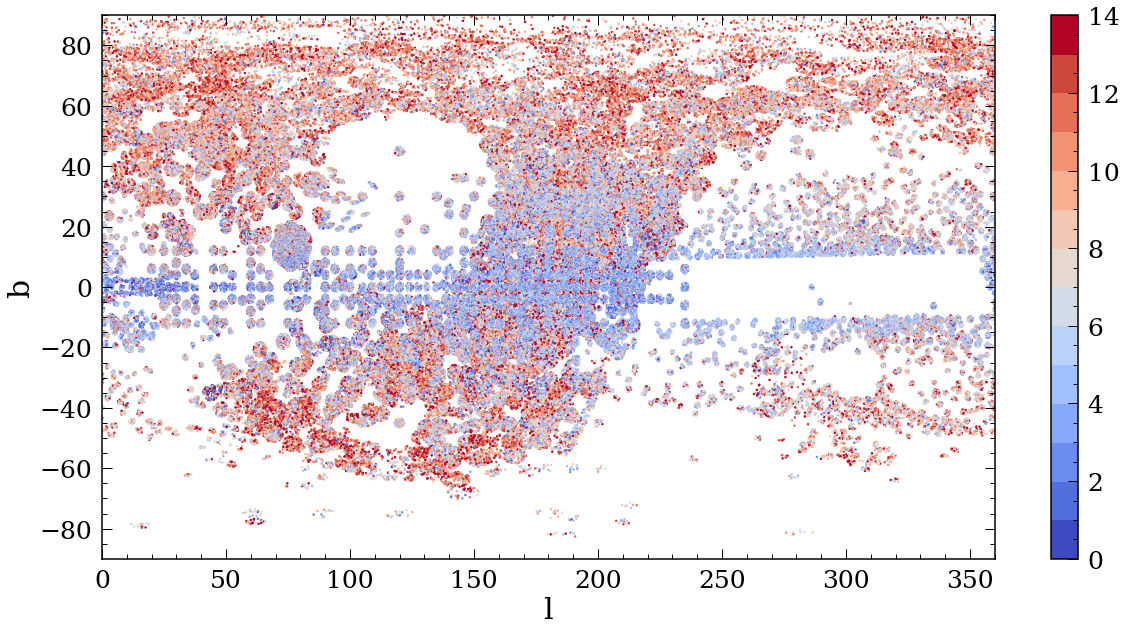

In [85]:
plt.figure(figsize=(20,10))
cm = plt.get_cmap('coolwarm',14)
plt.scatter(allages['l'],allages['b'],c=allages['age'],s=2,vmin=0,vmax=14,cmap=cm)
plt.xlim([0,360])
plt.ylim([-90,90])
plt.colorbar()
plt.xlabel('l')
plt.ylabel('b')
plt.savefig('allages.png')


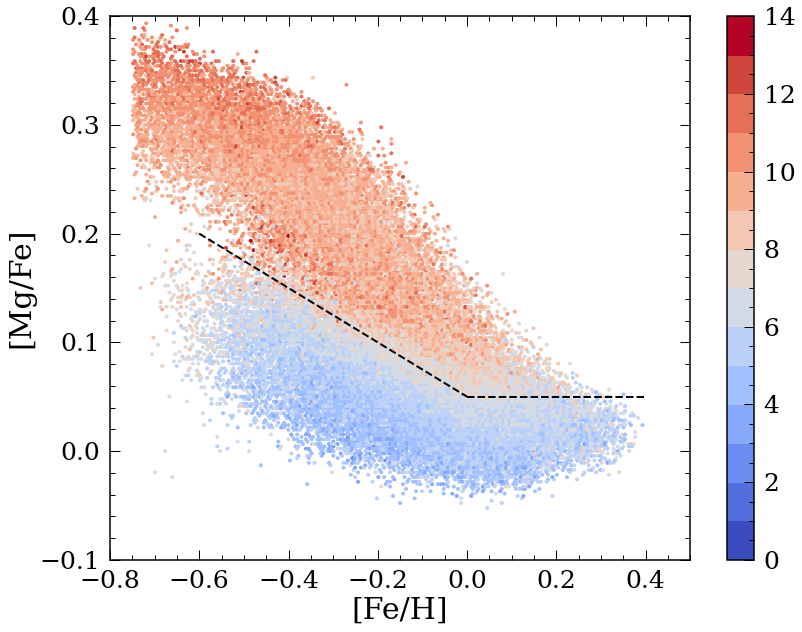

In [153]:
x1,x2,y1,y2=-0.8,0.5,-0.1,0.4
plt.figure(figsize=(13,10))
cm = plt.get_cmap('coolwarm',14)
plt.hexbin(allages['feh'],allages['mg_fe'],C=allages['age'],vmin=0,vmax=14,cmap=cm, gridsize=200,
           extent=(x1,x2,y1,y2),mincnt=10)
plt.plot([-0.6,0],[0.2,0.05],'k--')
plt.plot([0,0.4],[0.05,0.05],'k--')
plt.xlim([x1,x2])
plt.ylim([y1,y2])
plt.colorbar()
plt.xlabel('[Fe/H]')
plt.ylabel('[Mg/Fe]')

p=fitpoints([-0.6,0],[0.2,0.05])
p2=fitpoints([0,0.4],[0.05,0.05])


Text(0, 0.5, 'ΔP')

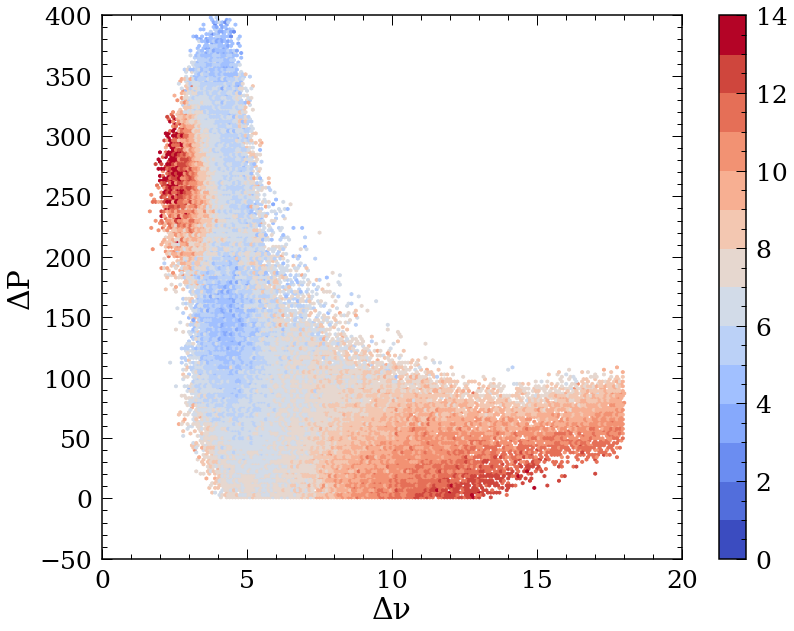

In [87]:
x1,x2,y1,y2=0,20,-50,400
plt.figure(figsize=(13,10))
cm = plt.get_cmap('coolwarm',14)

plt.hexbin(allages['Dnu'],allages['Dp'],C=allages['age'],vmin=0,vmax=14,cmap=cm, gridsize=200,
           extent=(x1,x2,y1,y2),mincnt=10)
"""    
plt.scatter(allages['Dnu'],allages['Dp'],c=allages['age'],vmin=0,vmax=14,cmap=cm,s=1)
"""
plt.xlim([x1,x2])
plt.ylim([y1,y2])
plt.colorbar()
plt.xlabel('Δν')
plt.ylabel('ΔP')
#plt.savefig('allages.png')




# add in distances

In [90]:

lamostages_dist=readfits('Data/LAMOST-dr5v3-gaia-edr3-coords-distances.fits')[['designation','r_med_geo']]
lamostages_dist=pd.merge(lamostages_dist,lamost_lb[['designation','obsid']],
                         left_on='designation',right_on='designation',how='inner')
print('LAMOST stars before merging with distances:',np.shape(lamostages))
lamostages_dist=pd.merge(lamostages,lamostages_dist,left_on='obsid',right_on='obsid',how='inner')
print('LAMOST stars after merging with distances:',np.shape(lamostages_dist))

lamostages_dist['dist']=lamostages_dist['r_med_geo']

galahages['dist']=galahages['r_est']
apogeeages['dist']=apogeeages['GAIA_R_EST']

mergcol=['l','b','age','feh','teff','logg','mg_fe','Dp','Dnu','dist']
allages_dist=pd.concat([galahages[mergcol],lamostages_dist[mergcol],apogeeages[mergcol]])



LAMOST stars before merging with distances: (258147, 22)
LAMOST stars after merging with distances: (208509, 24)


In [92]:
def convd2R(rad):
    return rad/180*np.pi

allages_dist['X'] = allages_dist.dist * np.cos(convd2R(allages_dist.b)) * np.cos(convd2R(allages_dist.l)) / 1000.
allages_dist['Y'] = -allages_dist.dist * np.sin(convd2R(allages_dist.l)) * np.cos(convd2R(allages_dist.b))/ 1000.
allages_dist['z'] = allages_dist.dist * np.sin(convd2R(allages_dist.b))/ 1000.
allages_dist['R'] = np.sqrt(np.power(allages_dist.X - 8.2,2.) + np.power(allages_dist.Y,2.))



Text(0, 0.5, 'Z [kpc]')

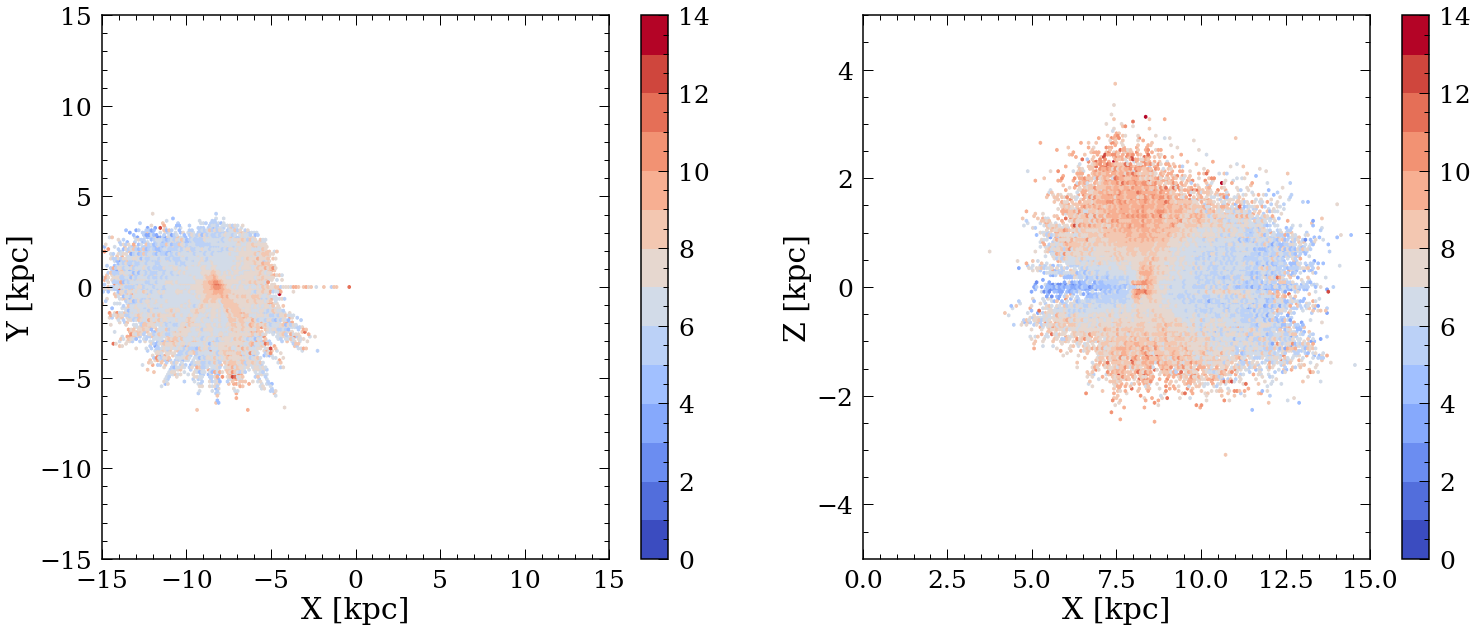

In [104]:
x1,x2,y1,y2=-15,15,-15,15
plt.figure(figsize=(25,10))
cm = plt.get_cmap('coolwarm',14)
plt.subplot(1,2,1)
plt.hexbin(allages_dist['X']-8.2,allages_dist['Y'],C=allages_dist['age'],vmin=0,vmax=14,cmap=cm, gridsize=200,
           extent=(x1,x2,y1,y2),mincnt=5)
plt.xlim([x1,x2])
plt.ylim([y1,y2])
plt.colorbar()
plt.xlabel('X [kpc]')
plt.ylabel('Y [kpc]')

x1,x2,y1,y2=0,15,-5,5
plt.subplot(1,2,2)
plt.hexbin(allages_dist['R'],allages_dist['z'],C=allages_dist['age'],vmin=0,vmax=14,cmap=cm, gridsize=200,
           extent=(x1,x2,y1,y2),mincnt=5)
plt.xlim([x1,x2])
plt.ylim([y1,y2])
plt.colorbar()
plt.xlabel('X [kpc]')
plt.ylabel('Z [kpc]')

<IPython.core.display.Javascript object>


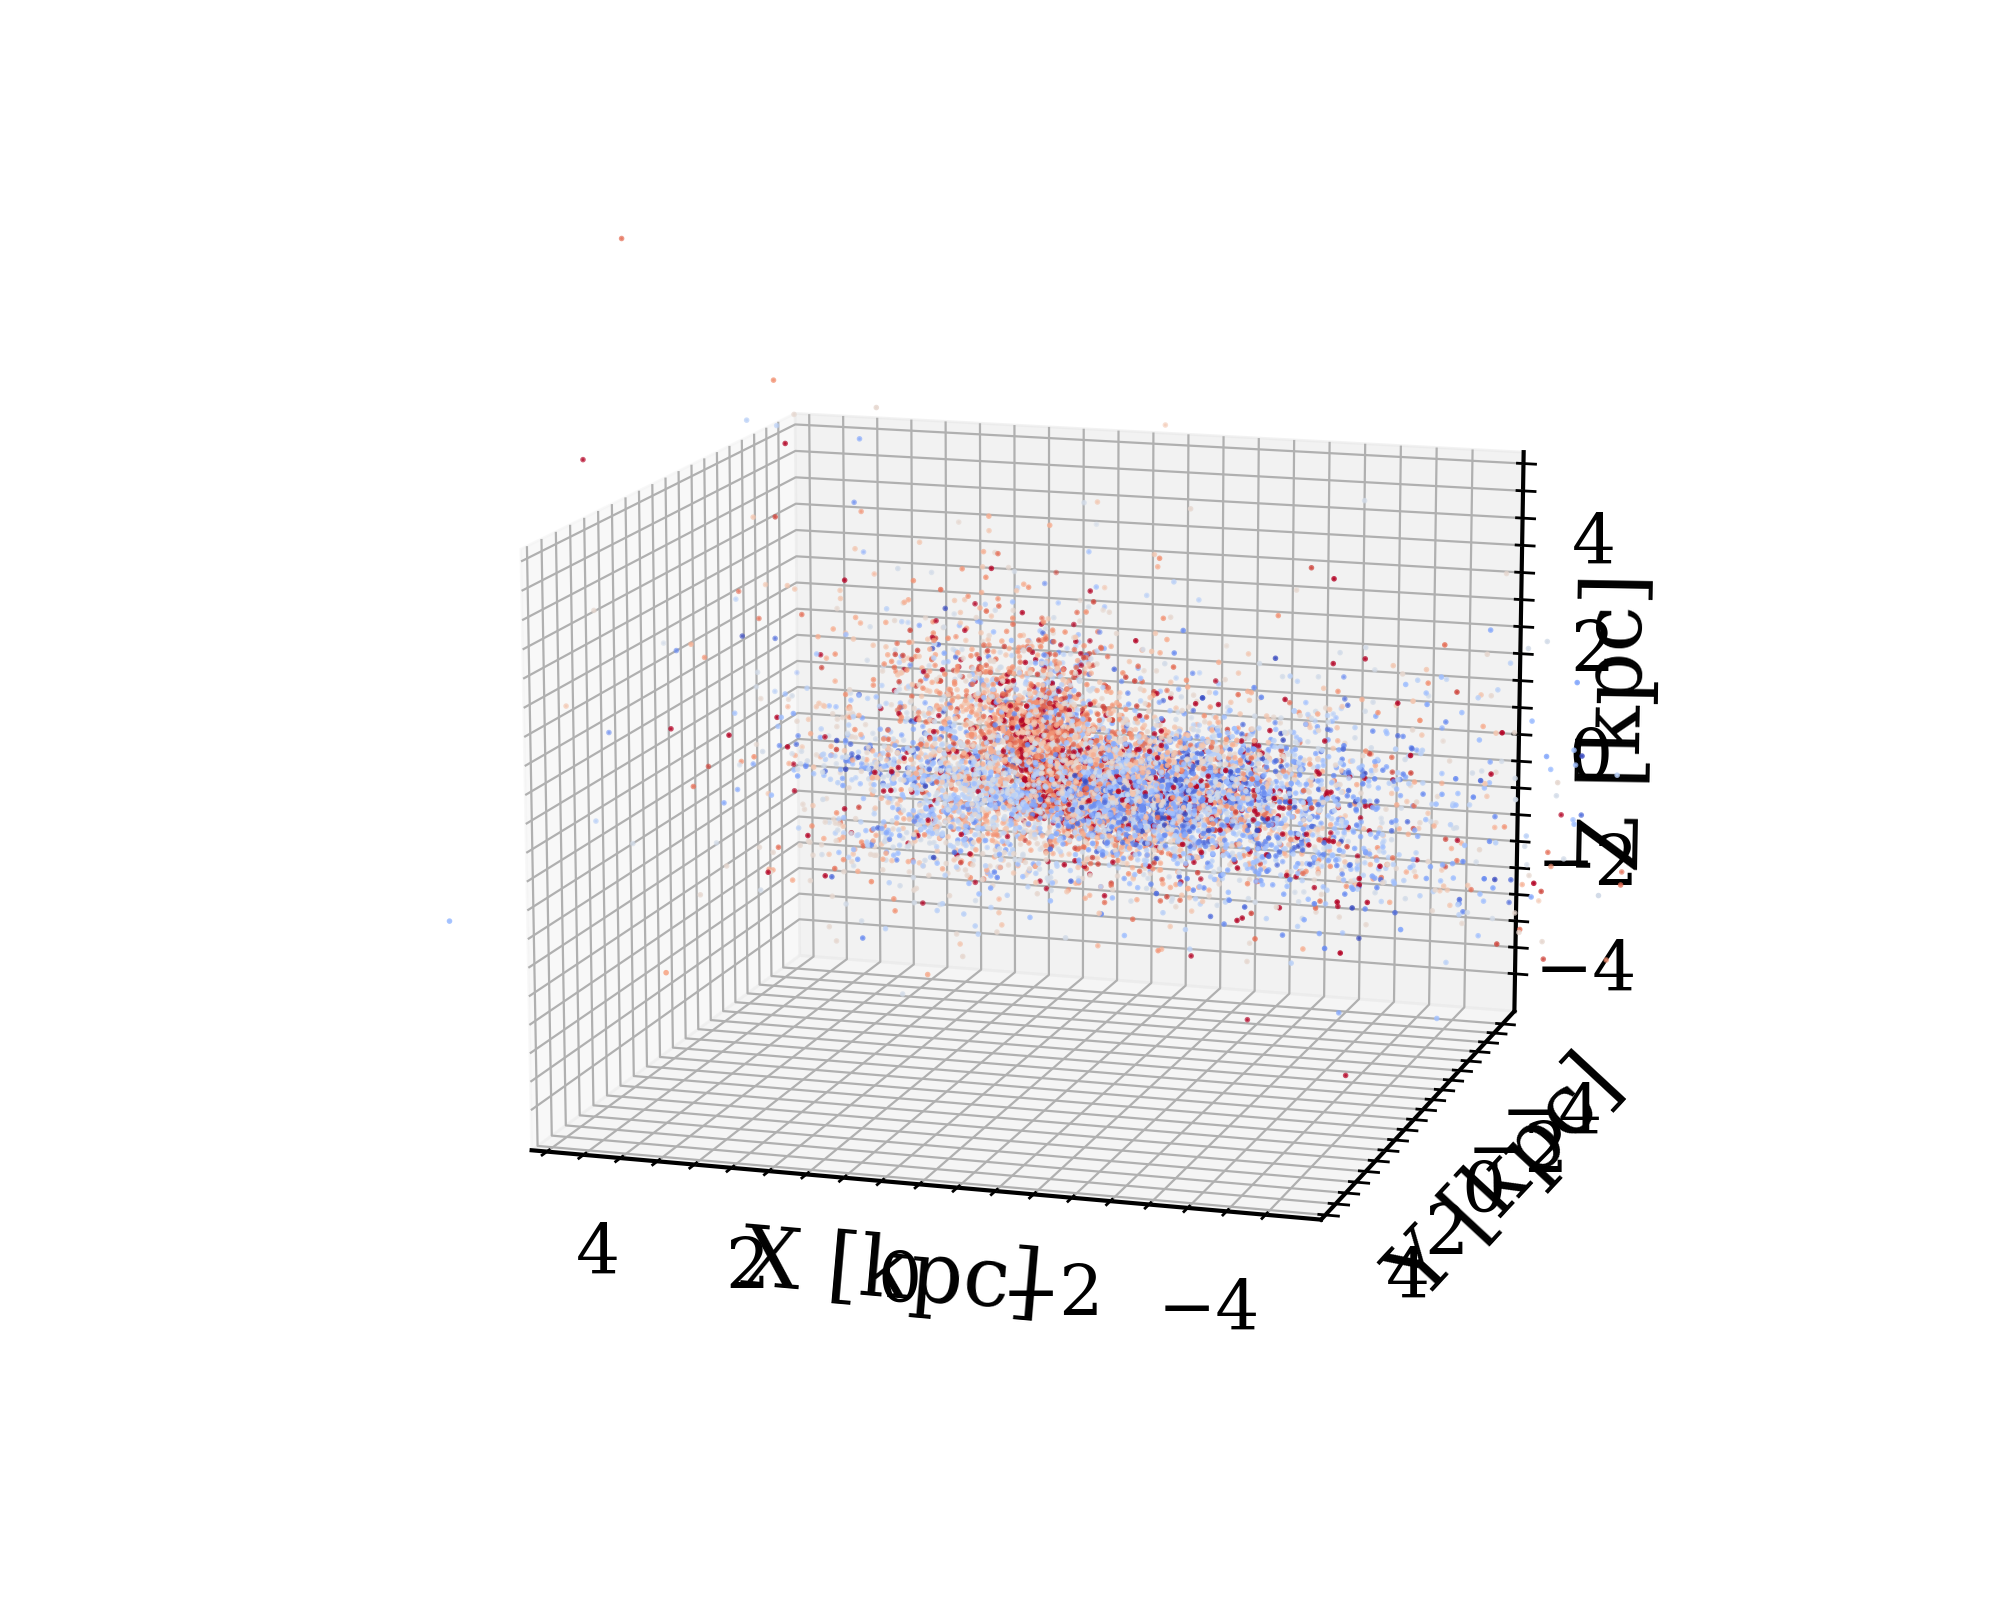

In [119]:
%matplotlib notebook
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d    
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
indices=list(range(len(allages_dist)))
random.shuffle(indices)
ax.scatter(allages_dist.iloc[indices[:10000]]['X'], 
           allages_dist.iloc[indices[:10000]]['Y'], 
           allages_dist.iloc[indices[:10000]]['z'], 
           c=allages_dist.iloc[indices[:10000]]['age'], s=1,vmin=0,vmax=14,cmap=cm)

ax.set_xlabel('X [kpc]')
ax.set_ylabel('Y [kpc]')
ax.set_zlabel('Z [kpc]')
ax.set_ylim([-5,5])
ax.set_zlim([-5,5])
ax.set_xlim([-5,5])

plt.show()


<ipython-input-154-b056b1415403>:51: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  plt.errorbar(meanage_ha,meanfeh_ha,xerr=meanage_err_ha,color=colors[k],
<ipython-input-154-b056b1415403>:55: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  plt.plot(filterage,meanfeh_ha[m2],'--',color=colors[k],linewidth=10)


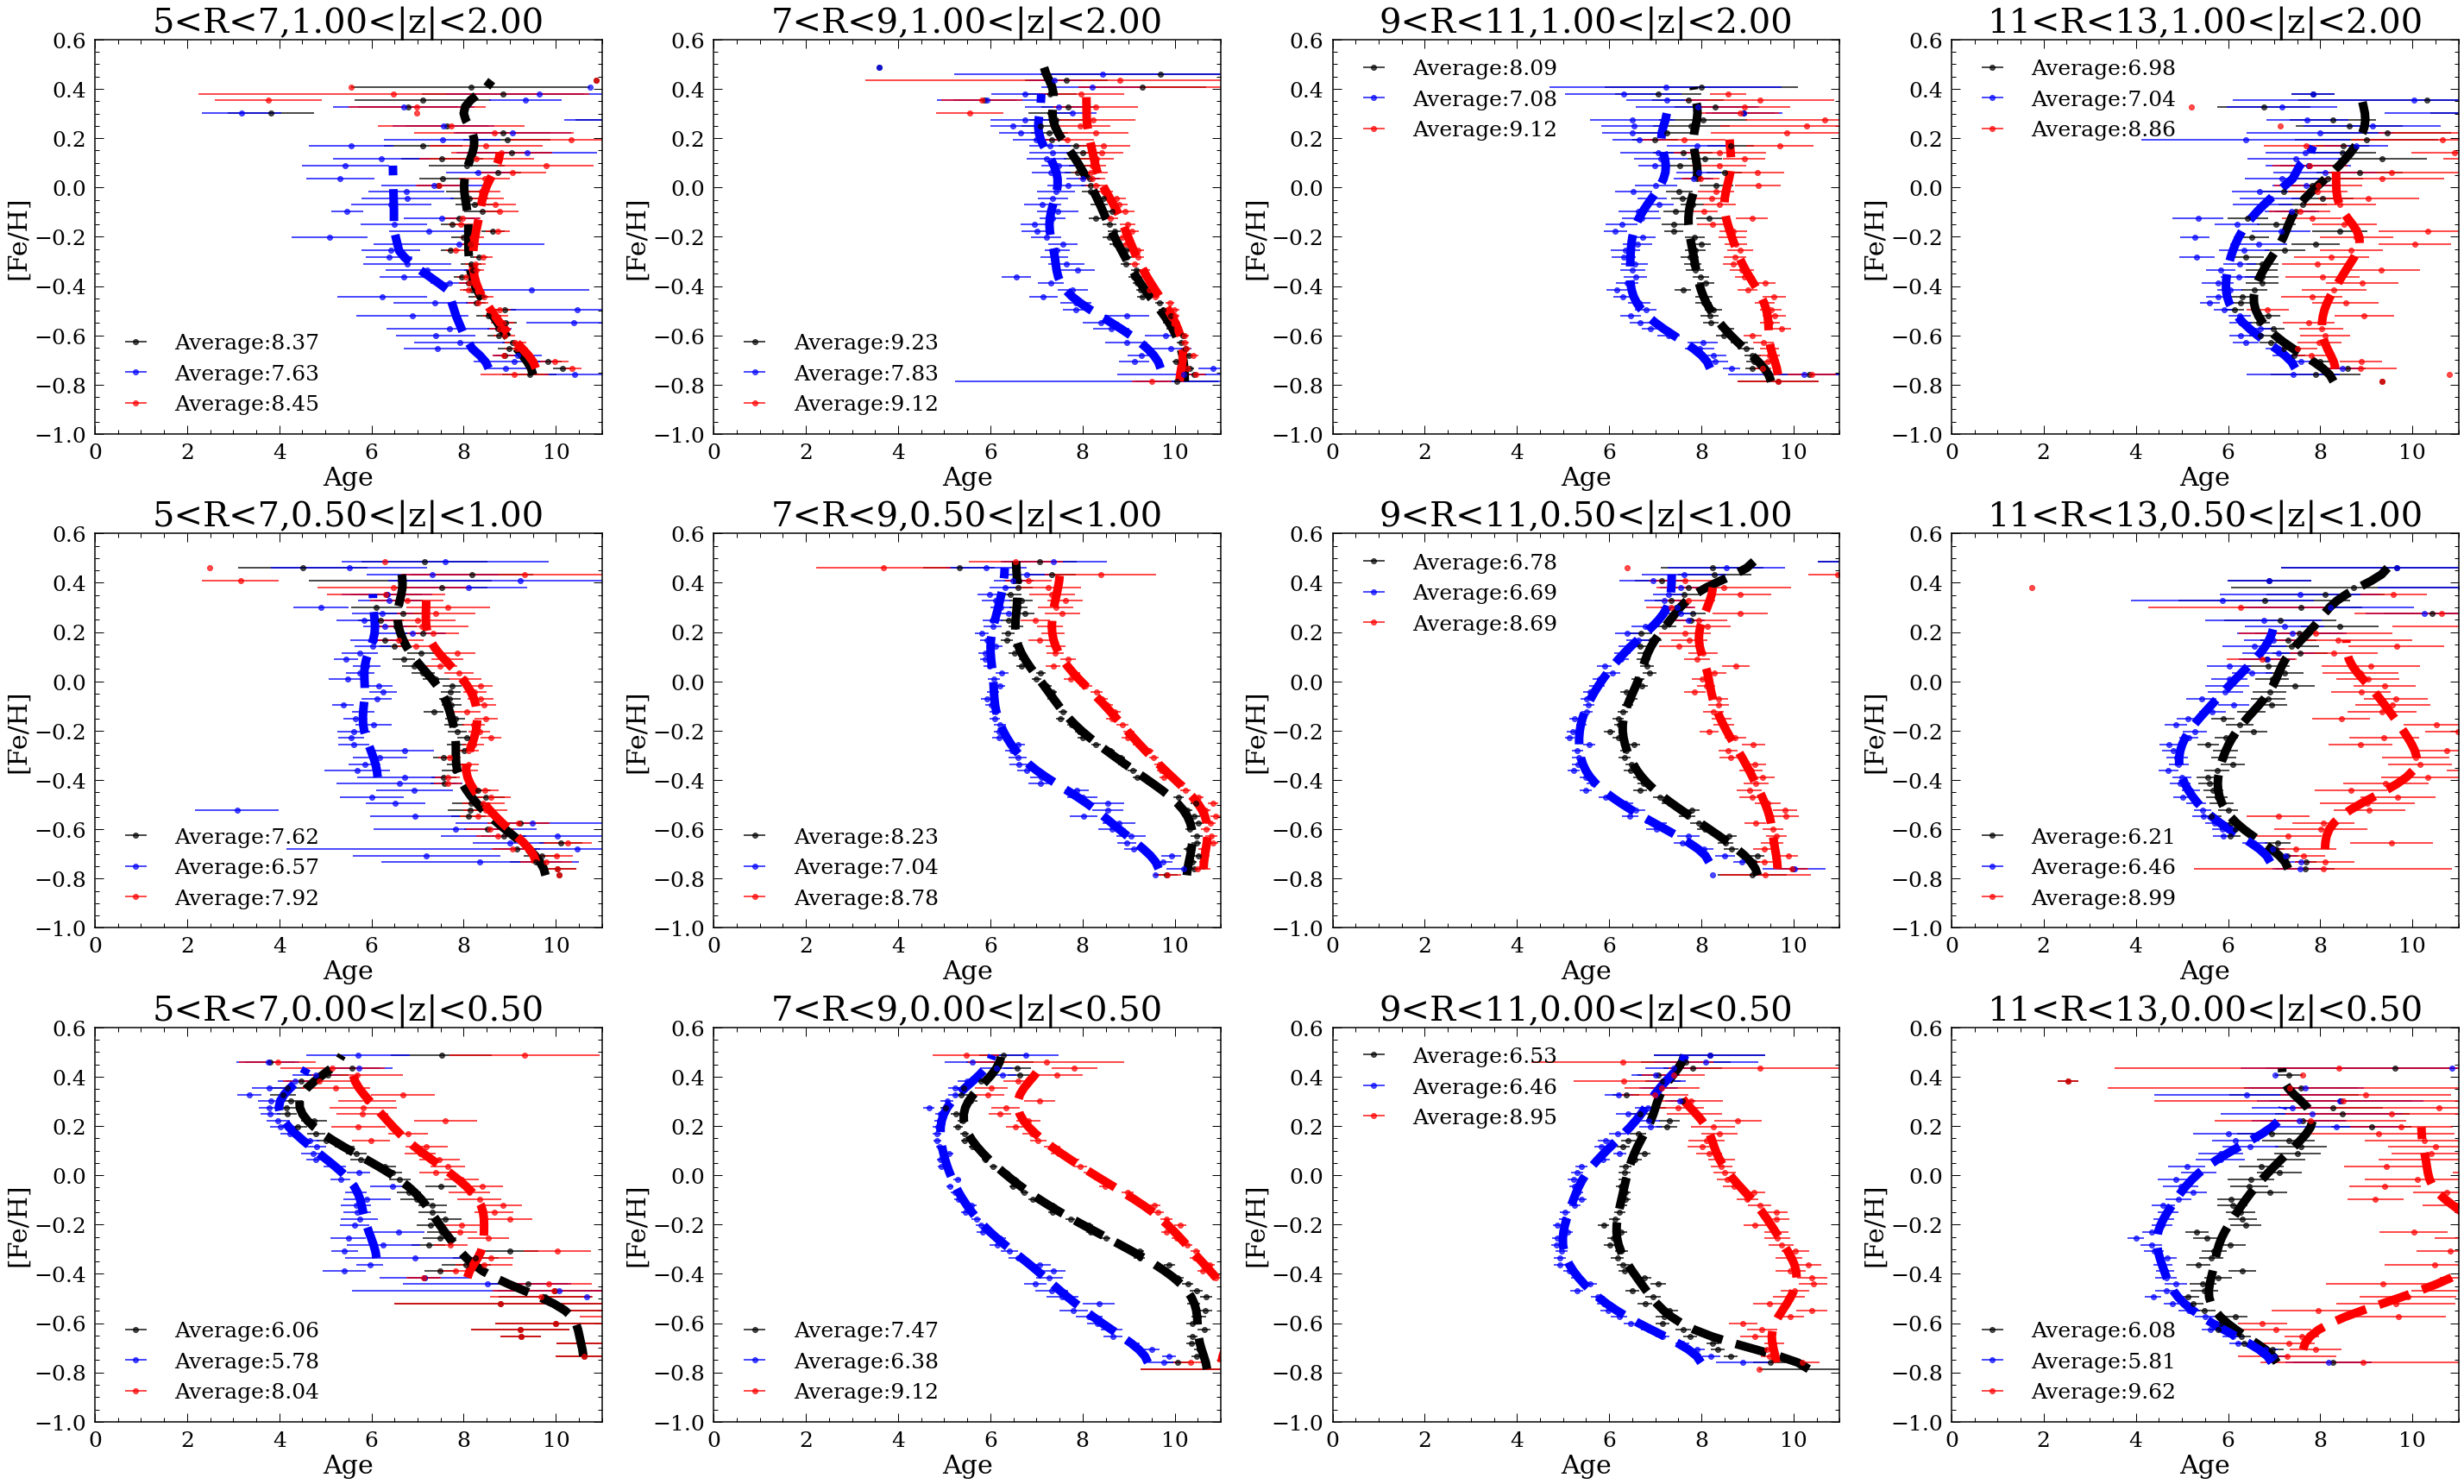

In [154]:
%matplotlib inline
# seperate high and low alpha disks
allages_dist['hi_low_1']=p(allages_dist['feh'])<allages_dist['mg_fe']
allages_dist['hi_low_2']=p2(allages_dist['feh'])<allages_dist['mg_fe']

m=allages_dist['feh']>0

hilow=allages_dist['hi_low_1']
hilow[m]=allages_dist['hi_low_2'].values[m]

allages_dist['hi_low']=hilow

# put into perspective
df_CM=allages_dist

Rbin=[2,1,0.5,0]
zbin=[5,7,9,11,13]
plt.figure(figsize=(40,24))
count=1
for i in range(len(Rbin)-1):
    df_all=df_CM.loc[df_CM['z']>Rbin[i+1]]
    df_all=df_all.loc[df_all['z']<Rbin[i]]
        
    for j in range(len(zbin)-1):
        df_all_z=df_all.loc[abs(df_all['R'])>zbin[j]]
        df_all_z=df_all_z.loc[abs(df_all_z['R'])<zbin[j+1]]
        
        df_all_z=df_all_z.dropna(subset=['feh','age'])
        
        meanfeh,meanage,meanage_err,starnumb=getave_age(df_all_z['age'],df_all_z['feh'])
        
        m=(meanfeh!=0)
        meanfeh,meanage,meanage_err,starnumb=meanfeh[m],meanage[m],meanage_err[m],starnumb[m]
        
        plt.subplot(3,4,count)
        plt.errorbar(meanage,meanfeh,xerr=meanage_err,fmt='ko',alpha=0.7,label='Average:%.2f'%np.mean(df_all_z['age']))
        filterage=gaussian_filter(meanage, sigma=3)
        plt.plot(filterage,meanfeh,'k--',linewidth=10)
        
        
        colors=['b','r','y']
        for k in df_CM['hi_low'].unique():
            ha_bin_z=df_all_z.loc[df_all_z['hi_low']==k]
            meanfeh_ha,meanage_ha,meanage_err_ha,starnumb_ha=getave_age(ha_bin_z['age'].values,
                                                                    ha_bin_z['feh'].values)
            
            m=(meanfeh_ha!=0)
            meanfeh_ha,meanage_ha,meanage_err_ha,starnumb_ha=meanfeh_ha[m],meanage_ha[m],meanage_err_ha[m],starnumb_ha[m]
            clear_output(wait = True)
            m2=starnumb_ha>10
            plt.errorbar(meanage_ha,meanfeh_ha,xerr=meanage_err_ha,color=colors[k],
                         fmt='o',alpha=0.7,label='Average:%.2f'%np.mean(meanage_ha))
        
            filterage=gaussian_filter(meanage_ha[m2], sigma=3)
            plt.plot(filterage,meanfeh_ha[m2],'--',color=colors[k],linewidth=10)
            
            #plt.scatter(meanage_ha,meanfeh_ha,c=colors[j],label='Average:%.2f'%np.mean(ha_bin_z['Age']))
            
        
            #plt.xlim([0,10])
            #plt.ylim([-2,0.5])
        plt.xlabel('Age')
        plt.ylabel('[Fe/H]')
        """
        if count==10:
            plt.plot([4.66],[0],'bo',markersize=30)
        """    
        plt.xlim([0,11])
        plt.ylim([-1,0.6])
        plt.legend()
        count=count+1
        plt.title('%d<R<%d,%.2f<|z|<%.2f'%(zbin[j],zbin[j+1],Rbin[i+1],Rbin[i]),fontsize=40)
plt.tight_layout()
        
plt.savefig('FeAge_allages.png')

In [155]:
from scipy.stats import skew
def calcaverage(df):
    #xgrit=np.linspace(min(df['R']),max(df['R']),50)
    #ygrit=np.linspace(min(df['z']),max(df['z']),50)
    r_range=50
    z_range=25
    R=np.linspace(0,20,r_range)
    z=np.linspace(-5,5,z_range)
    R_grid=[]
    z_grid=[]
    age_grid=[]
    count=0
    for i in trange(r_range-1):
        for j in range(z_range-1):
            R_grid.append((R[i]+R[i+1])/2.)
            z_grid.append((z[j]+z[j+1])/2.)
            
            df_grid=df.loc[df['R']>R[i]]
            #print(len(df_grid))
            df_grid=df_grid.loc[df_grid['R']<R[i+1]]
            #print(len(df_grid))
            df_grid=df_grid.loc[df_grid['z']>z[j]]
            #print(len(df_grid))
            df_grid=df_grid.loc[df_grid['z']<z[j+1]]
            #print(len(df_grid))
            
            df_grid=df_grid.dropna(subset=['feh'])
            df_grid=df_grid.loc[~(df_grid['feh']==-9999)]
            if len(df_grid)>20:
                #age_grid.append(3*(np.mean(df_grid['M_H'])-np.median(df_grid['M_H']))/np.std(df_grid['M_H']))
                age_grid.append(skew(df_grid['feh'].values))
                #print(skew(df_grid['M_H'].values))
            else:
                age_grid.append(np.nan)
            #print(df_grid['Age'])
    #print(age_grid)
    return R_grid,z_grid,age_grid

In [156]:
R_grid,z_grid,screwness=calcaverage(df_CM)
R_grid,z_grid,screwness_la=calcaverage(df_CM.loc[df_CM['hi_low']==0].reset_index(drop=True))
R_grid,z_grid,screwness_ha=calcaverage(df_CM.loc[df_CM['hi_low']==1].reset_index(drop=True))


100%|██████████| 49/49 [00:04<00:00, 11.38it/s]


In [157]:
skrewness=pd.DataFrame(np.array((R_grid,z_grid,screwness,screwness_la,screwness_ha)).T,columns=['R','z','skew','skew_la','skew_ha'])
skrewness.to_pickle('../skewness_scipy.pkl')
skrewness

R         z  skew  skew_la  skew_ha
0      0.204082 -4.791667   NaN      NaN      NaN
1      0.204082 -4.375000   NaN      NaN      NaN
2      0.204082 -3.958333   NaN      NaN      NaN
3      0.204082 -3.541667   NaN      NaN      NaN
4      0.204082 -3.125000   NaN      NaN      NaN
...         ...       ...   ...      ...      ...
1171  19.795918  3.125000   NaN      NaN      NaN
1172  19.795918  3.541667   NaN      NaN      NaN
1173  19.795918  3.958333   NaN      NaN      NaN
1174  19.795918  4.375000   NaN      NaN      NaN
1175  19.795918  4.791667   NaN      NaN      NaN

[1176 rows x 5 columns]

In [158]:
skrewness=pd.read_pickle('../skewness_scipy.pkl')

0.28633757917318753 0.34459529296940444


/Users/yl4331/Desktop/CreateDataTable/HeaderP.py:1173: RuntimeWarning: invalid value encountered in true_divide
  image = hist1/hist1_norm
/Users/yl4331/Desktop/CreateDataTable/HeaderP.py:1173: RuntimeWarning: invalid value encountered in true_divide
  image = hist1/hist1_norm
/Users/yl4331/Desktop/CreateDataTable/HeaderP.py:1173: RuntimeWarning: invalid value encountered in true_divide
  image = hist1/hist1_norm


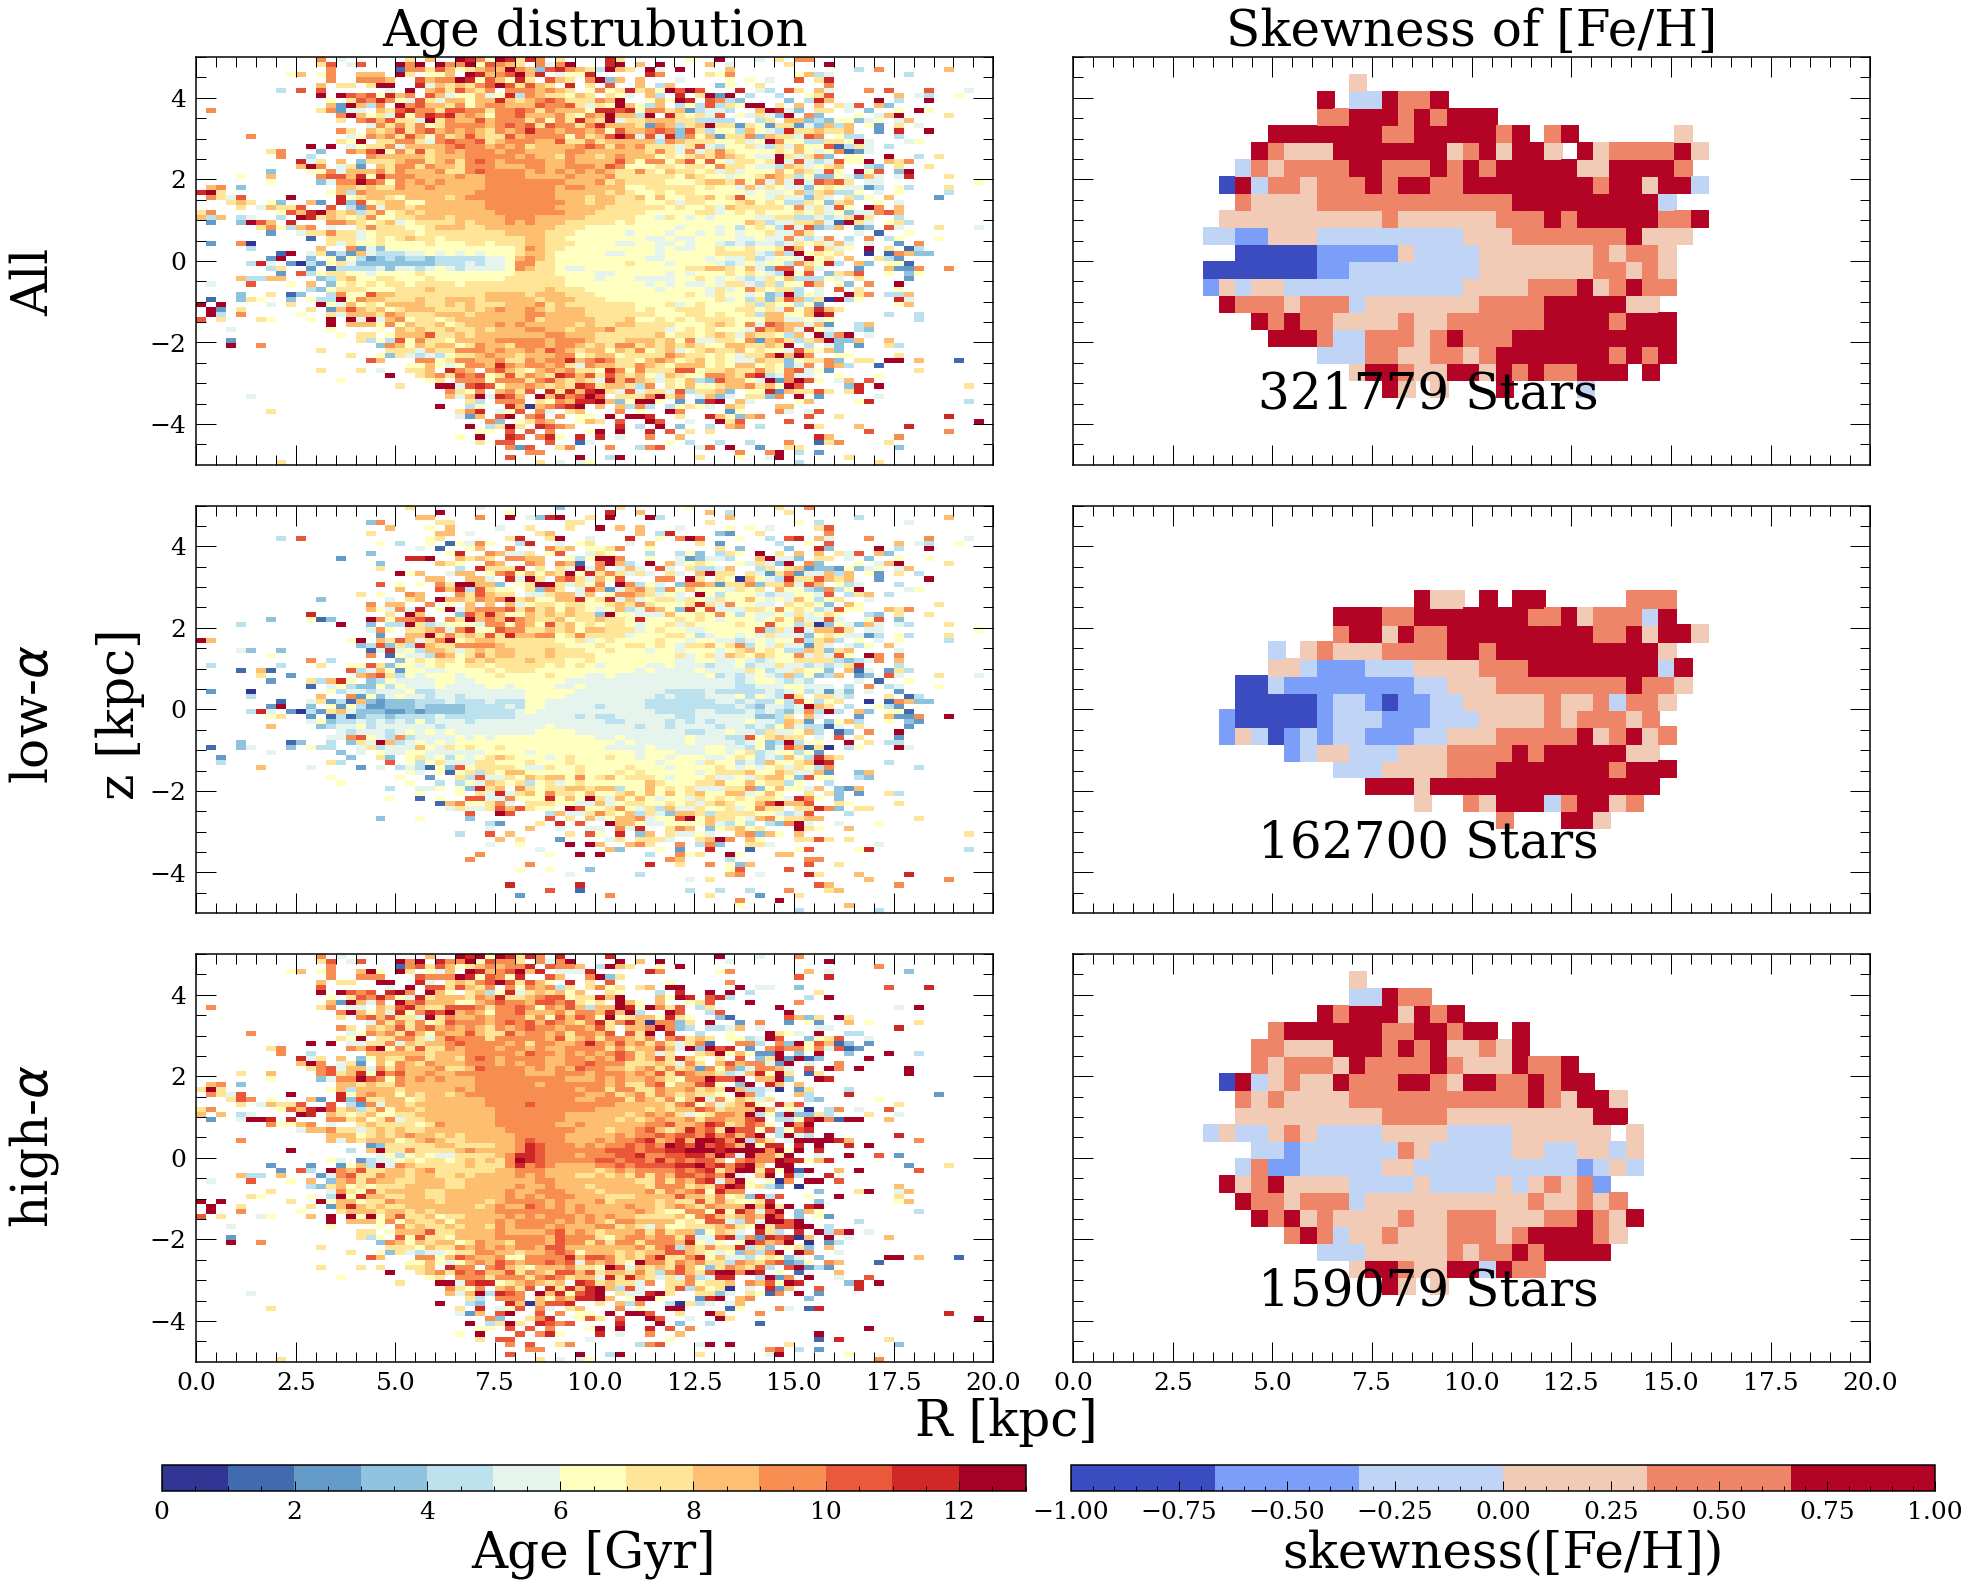

In [159]:

x1,x2,y1,y2 = 0,20,-5,5
lims = [x1,x2,y1,y2]
lims = np.array(lims)
binnum = 80


fig, axarr = plt.subplots(3,2,gridspec_kw={'hspace': 0.1, 'wspace': 0.1},
                          figsize=(30,24))

cm = plt.cm.get_cmap('coolwarm',6)
im=axarr[0,1].scatter(skrewness['R'],skrewness['z'],marker='s',c=skrewness['skew'],
                   cmap=cm,vmin=-1,vmax=1,s=300,alpha=1)
axarr[0,1].set_xlim([0,20])
axarr[0,1].set_ylim([-5,5])
axarr[0,1].set_title('Skewness of [Fe/H]',fontsize=50)
axarr[0,1].set_yticklabels([])
axarr[0,1].set_xticklabels([])
axarr[0,1].plot(-1000,-1000,'.',markersize=0.01,label='%d Stars'%len(df_CM))
axarr[0,1].legend(fontsize=50)
axarr[0,1].tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=20)
axarr[0,1].tick_params(which='minor', length=10, direction='in',top=True,right=True)

m=skrewness['R']<16
skrewness=skrewness[m]
im=axarr[1,1].scatter(skrewness['R'],skrewness['z'],marker='s',c=skrewness['skew_la'],
                   cmap=cm,vmin=-1,vmax=1,s=300,alpha=1)
axarr[1,1].set_xlim([0,20])
axarr[1,1].set_ylim([-5,5])
axarr[1,1].set_yticklabels([])
axarr[1,1].set_xticklabels([])
axarr[1,1].plot(-1000,-1000,'.',markersize=0.01,label='%d Stars'%sum(df_CM['hi_low']==0))
axarr[1,1].legend(fontsize=50)
axarr[1,1].tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=20)
axarr[1,1].tick_params(which='minor', length=10, direction='in',top=True,right=True)


im=axarr[2,1].scatter(skrewness['R'],skrewness['z'],marker='s',c=skrewness['skew_ha'],
                   cmap=cm,vmin=-1,vmax=1,s=300,alpha=1)

print(np.median(skrewness['skew_ha'].dropna()),np.mean(skrewness['skew_ha'].dropna()))

axarr[2,1].set_xlim([0,20])
axarr[2,1].set_ylim([-5,5])
axarr[2,1].plot(-1000,-1000,'.',markersize=0.01,label='%d Stars'%sum(df_CM['hi_low']==1))
axarr[2,1].legend(fontsize=50)
axarr[2,1].set_yticklabels([])
axarr[2,1].tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=20)
axarr[2,1].tick_params(which='minor', length=10, direction='in',top=True,right=True)

cb_ax = fig.add_axes([0.53, 0.05, 0.4, 0.015])
cbar = fig.colorbar(im, cax=cb_ax,orientation = 'horizontal')
car = cbar.set_label('skewness([Fe/H])',fontsize = 50,labelpad = 5)



cmap1 = plt.cm.get_cmap('RdYlBu_r',13)
cmap1.set_bad('white',1.)

image=makeagemap_each(df_CM['R'].values,df_CM['z'].values,
                df_CM['age'].values,lims, binnum)
axarr[0,0].imshow(image.T, interpolation="nearest" ,aspect = 'auto',origin = 'lower', 
           extent = (x1,x2, y1,y2),cmap=cmap1, vmin=0,vmax=13)
axarr[0,0].set_title('Age distrubution',fontsize=50)
axarr[0,0].set_xticklabels([])
axarr[0,0].tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=20)
axarr[0,0].tick_params(which='minor', length=10, direction='in',top=True,right=True)


image=makeagemap_each(df_CM.loc[df_CM['hi_low']==0]['R'].values,df_CM.loc[df_CM['hi_low']==0]['z'].values,
                df_CM['age'].loc[df_CM['hi_low']==0].values,lims, binnum)
im=axarr[1,0].imshow(image.T, interpolation="nearest" ,aspect = 'auto',origin = 'lower', 
           extent = (x1,x2, y1,y2),cmap=cmap1, vmin=0,vmax=13)
axarr[1,0].set_xticklabels([])
axarr[1,0].tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=20)
axarr[1,0].tick_params(which='minor', length=10, direction='in',top=True,right=True)

image=makeagemap_each(df_CM.loc[df_CM['hi_low']==1]['R'].values,df_CM.loc[df_CM['hi_low']==1]['z'].values,
                df_CM['age'].loc[df_CM['hi_low']==1].values,lims, binnum)
#print(np.median(image))
axarr[2,0].imshow(image.T, interpolation="nearest" ,aspect = 'auto',origin = 'lower', 
           extent = (x1,x2, y1,y2),cmap=cmap1, vmin=0,vmax=13)
axarr[2,0].tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=20)
axarr[2,0].tick_params(which='minor', length=10, direction='in',top=True,right=True)

cb_ax = fig.add_axes([0.109, 0.05, 0.4, 0.015])
cbar = fig.colorbar(im, cax=cb_ax,orientation = 'horizontal')
car = cbar.set_label('Age [Gyr]',fontsize = 50,labelpad = 5)

fig.text(0.09, 0.5, 'z [kpc]', ha='center', va='center', rotation='vertical',fontsize=50)
fig.text(0.5, 0.09, 'R [kpc]', ha='center', va='center', rotation='horizontal',fontsize=50)
"""
fig.text(0.05, 0.75, 'All %d'%len(df_CM), ha='center', va='center', rotation='vertical',fontsize=50)
fig.text(0.05, 0.5, '%d low-$\\alpha$'%len(df_CM.loc[df_CM['hi_low_line']==0]),
         ha='center', va='center', rotation='vertical',fontsize=50)
fig.text(0.05, 0.25, '%d high-$\\alpha$'%len(df_CM.loc[df_CM['hi_low_line']==1]), 
         ha='center', va='center', rotation='vertical',fontsize=50)
"""
fig.text(0.05, 0.75, 'All', ha='center', va='center', rotation='vertical',fontsize=50)
fig.text(0.05, 0.5, 'low-$\\alpha$',
         ha='center', va='center', rotation='vertical',fontsize=50)
fig.text(0.05, 0.25, 'high-$\\alpha$', 
         ha='center', va='center', rotation='vertical',fontsize=50)


plt.savefig('fehskew.png')




  0%|          | 0/9 [00:00<?, ?it/s]/Users/yl4331/Desktop/CreateDataTable/HeaderP.py:1173: RuntimeWarning: invalid value encountered in true_divide
  image = hist1/hist1_norm
/Users/yl4331/Desktop/CreateDataTable/HeaderP.py:1173: RuntimeWarning: invalid value encountered in true_divide
  image = hist1/hist1_norm
/Users/yl4331/Desktop/CreateDataTable/HeaderP.py:1173: RuntimeWarning: invalid value encountered in true_divide
  image = hist1/hist1_norm
/Users/yl4331/Desktop/CreateDataTable/HeaderP.py:1173: RuntimeWarning: invalid value encountered in true_divide
  image = hist1/hist1_norm
/Users/yl4331/Desktop/CreateDataTable/HeaderP.py:1173: RuntimeWarning: invalid value encountered in true_divide
  image = hist1/hist1_norm
/Users/yl4331/Desktop/CreateDataTable/HeaderP.py:1173: RuntimeWarning: invalid value encountered in true_divide
  image = hist1/hist1_norm
/Users/yl4331/Desktop/CreateDataTable/HeaderP.py:1173: RuntimeWarning: invalid value encountered in true_divide
  image = hist1/h

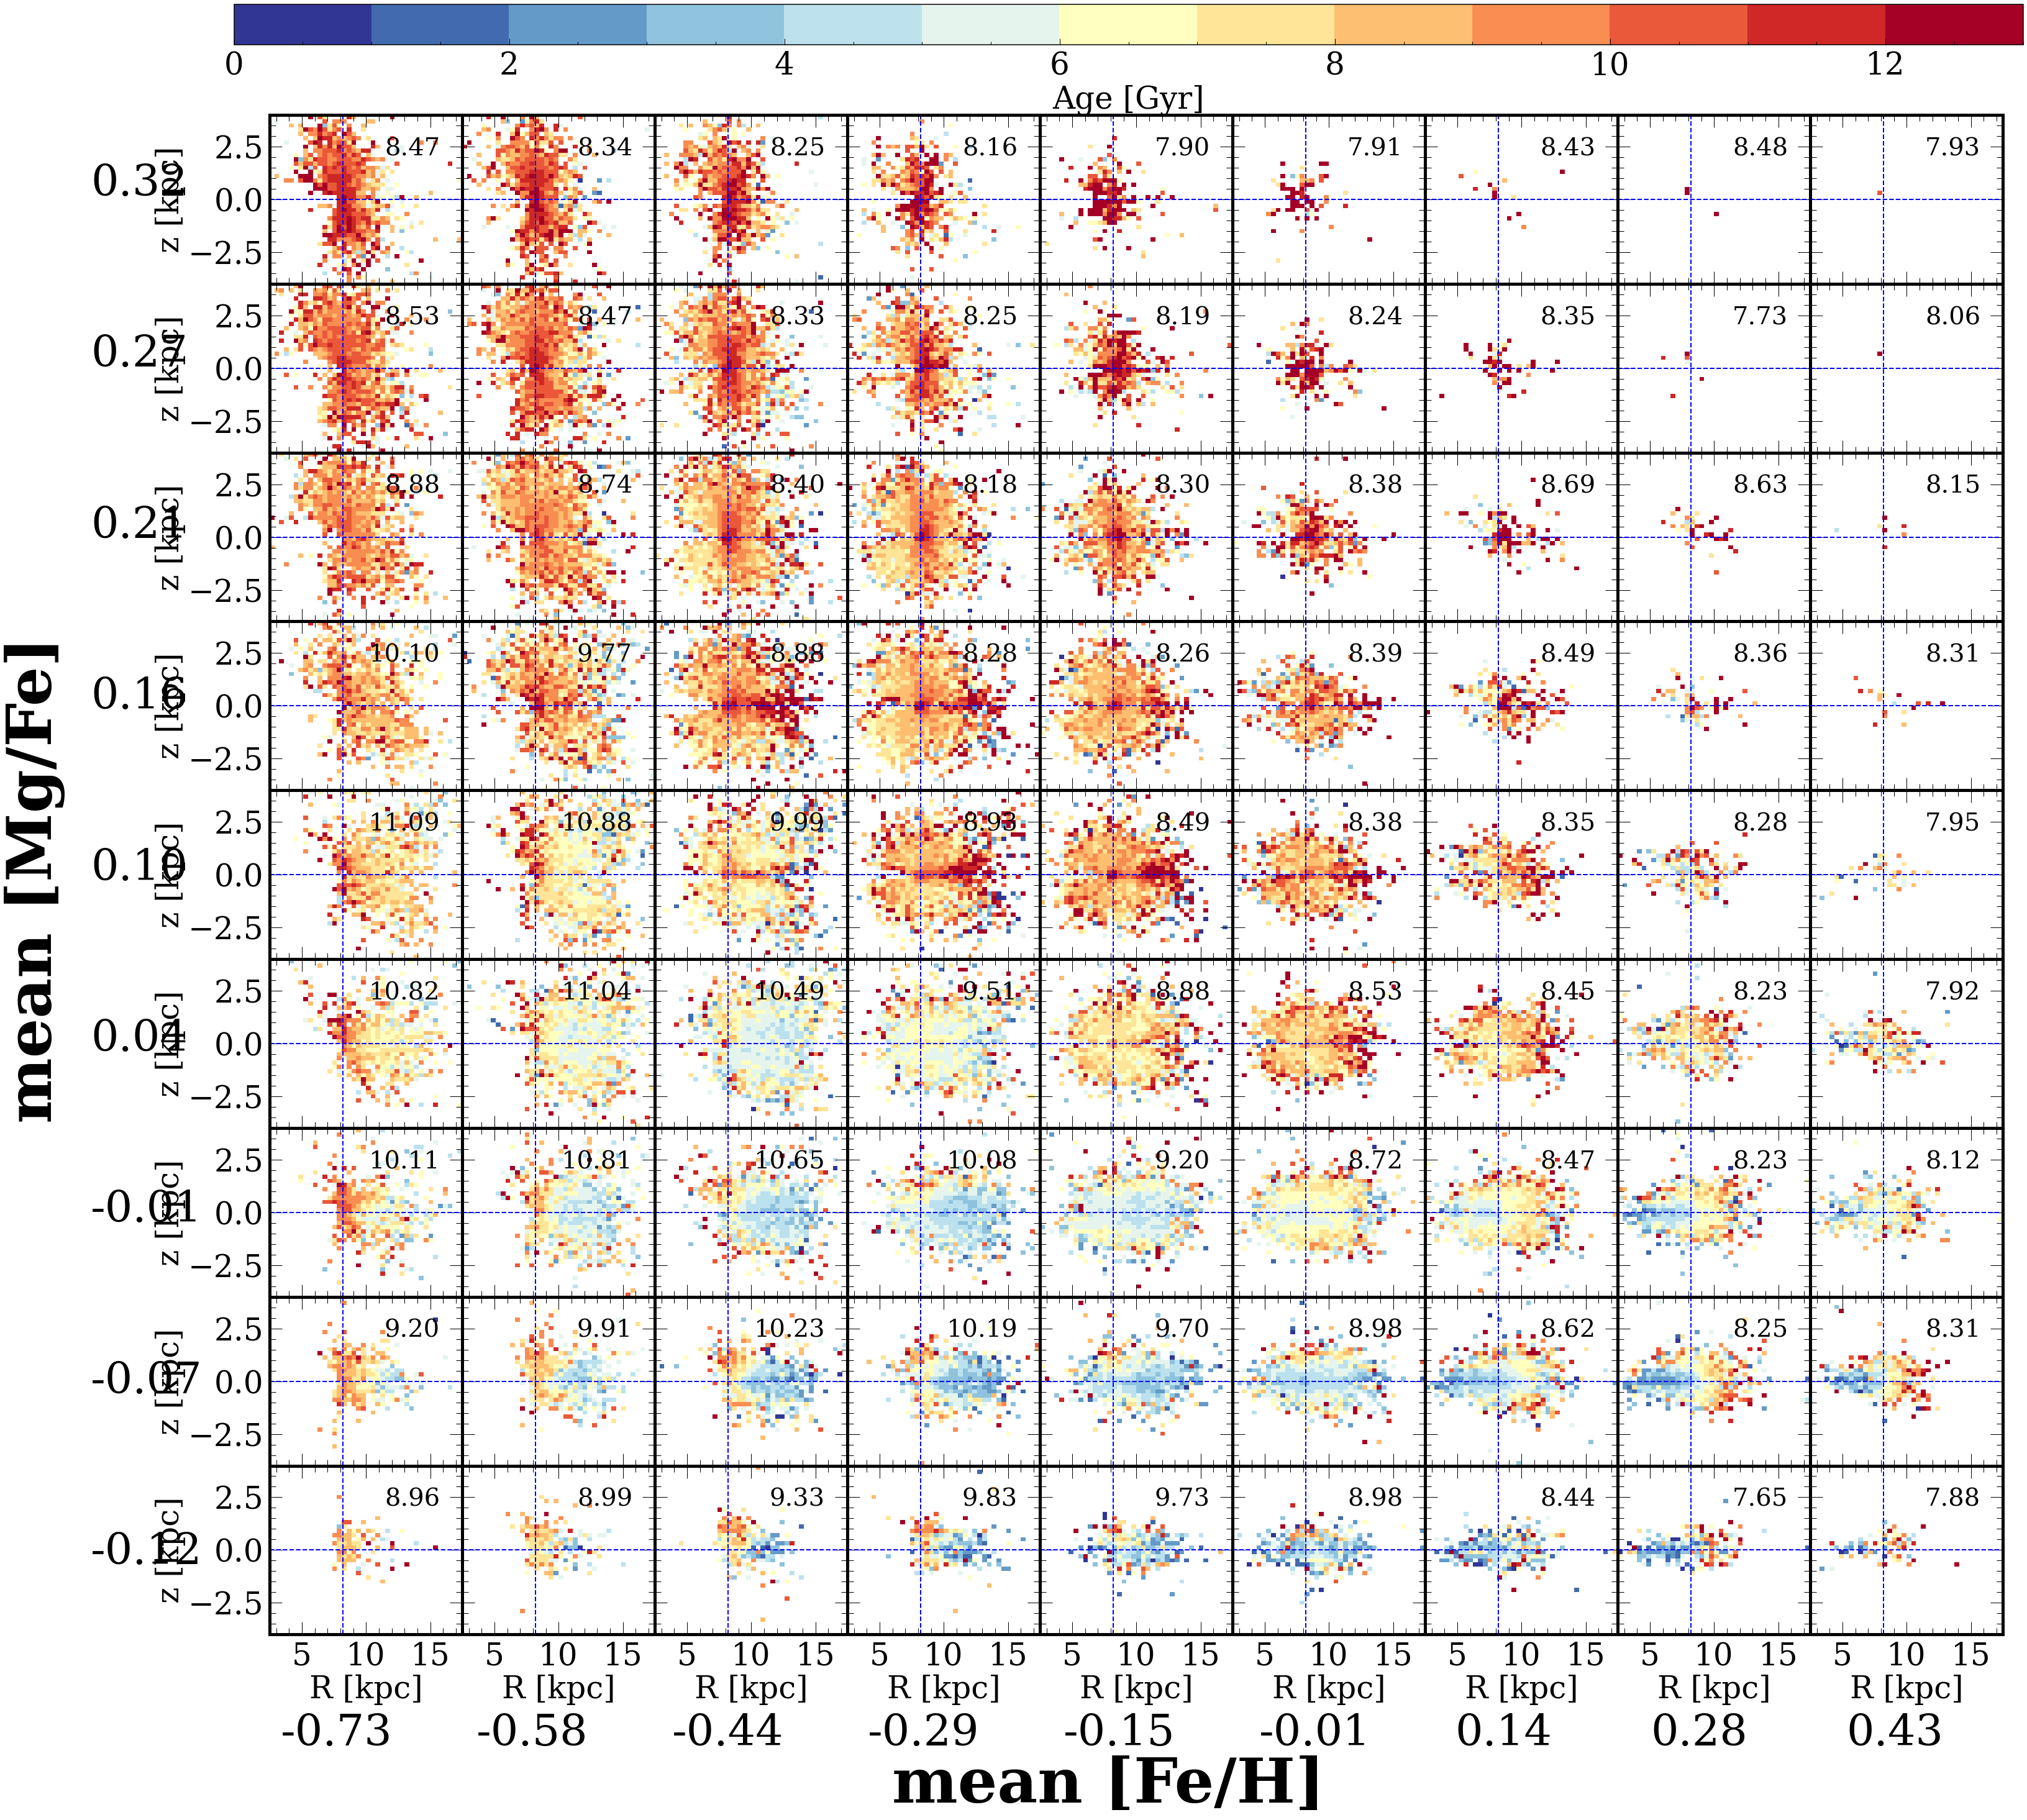

In [162]:
from scipy.ndimage import gaussian_filter
import math
from matplotlib import rc
rc('text', usetex=False) 
#Febin=np.linspace(-0.8,0.5,10)
#alpha=np.linspace(0.3,-0.05,10)
Febin=np.linspace(-0.8,0.5,10)
alpha=np.linspace(0.4,-0.1,10)

#plt.figure(figsize=(len(Febin)*10-10,len(alpha)*10-10))

x1,x2,y1,y2 = 2.5,17.5,-4,4
lims = [x1,x2,y1,y2]
lims = np.array(lims)
binnum = 40

#df_CM=df_CM.loc[df_CM['Age_err']<5]
print(len(df_CM))

fig, axarr = plt.subplots(len(alpha)-1,len(Febin)-1,gridspec_kw={'hspace': 0, 'wspace': 0},
                          figsize=(len(Febin)*5,len(alpha)*5-5))
count=0


for i in range(len(alpha)-1):
    print(i/(len(alpha)-1))
    clear_output(wait = True)
    
    df_all=df_CM.loc[df_CM['mg_fe']>alpha[i+1]]
    df_all=df_all.loc[df_all['mg_fe']<alpha[i]]
    #print(len(df_all))
    
    for j in trange(len(Febin)-1):
        df_all_z=df_all.loc[(df_all['feh'])>Febin[j]]
        df_all_z=df_all_z.loc[(df_all_z['feh'])<Febin[j+1]]
        
        #print(len(df_all_z))
        image=makeagemap_each(df_all_z['R'].values,df_all_z['z'].values,
                df_all_z['age'].values,lims, binnum)
        
        
        cmap1 = plt.cm.get_cmap('RdYlBu_r',13)
        cmap1.set_bad('white',1.)
    
        x1m,x2m,y1m,y2m = lims[0], lims[1], lims[2], lims[3]
        
        
        im=axarr[i,j].imshow(image.T, interpolation="nearest" ,aspect = 'auto',origin = 'lower', 
                   extent = (x1m,x2m, y1m,y2m),cmap=cmap1, vmin=0,vmax=13)
        if math.isnan(np.mean(df_all_z['R'])):
            axarr[i,j].plot([-1000,1000],'k.',markersize=0.001)
        else:
            axarr[i,j].plot([-1000,1000],'k.',markersize=0.001,label='%.2f'%np.mean(df_all_z['R']))
            
        for axis in ['top','bottom','left','right']:
            axarr[i,j].spines[axis].set_linewidth(5)
        
        axarr[i,j].plot([x1m,x2m],[0,0],'b--')
        axarr[i,j].plot([8.2,8.2],[y1m,y2m],'b--')
        axarr[i,j].legend(prop={'size': 40})
        
        #axarr[i,j].set_linewidth(3)
        count=count+1
        if j!=0:
            axarr[i,j].set_yticklabels([])
        else:
            axarr[i,j].set_ylabel('z [kpc]',fontsize=50) 
        if i!=len(alpha)-2:
            axarr[i,j].set_xticklabels([])
        else:
            axarr[i,j].set_xlabel('R [kpc]',fontsize=50) 
   
        
        axarr[i,j].set_xlim(x1m,x2m)
        axarr[i,j].set_ylim(y1m,y2m)

       # if i==len(alpha)-2 and j==0:
       #     axarr[i,j].set_xlabel('R [kpc]',fontsize=50) 
       #     axarr[i,j].set_ylabel('z [kpc]',fontsize=50) 
        axarr[i,j].tick_params(which='major',labelsize=50,direction='in',top=True,right=True,length=20)
        axarr[i,j].tick_params(which='minor', length=10, direction='in',top=True,right=True)

        
cb_ax = fig.add_axes([0.109, 0.915, 0.8, 0.02])
cbar = fig.colorbar(im, cax=cb_ax,orientation = 'horizontal')
cbar.ax.tick_params(labelsize=50) 
car = cbar.set_label('Age [Gyr]',fontsize = 50,labelpad = 5)


fig.text(0.02, 0.5, 'mean [Mg/Fe]', ha='center', va='center', rotation='vertical',fontsize=100, fontweight='bold')
fig.text(0.5, 0.05, 'mean [Fe/H]', ha='center', va='center', rotation='horizontal',fontsize=100, fontweight='bold')

    
for i in range(0,10-1):
    fig.text(0.045, 0.16+0.085*i, '%.2f'%((0.3-alpha[i]-0.05+0.3-alpha[i+1]-0.05)/2.), rotation='horizontal',
             fontsize=70)
    fig.text(0.13+0.0875*i, 0.07, '%.2f'%((Febin[i]+Febin[i+1])/2.), rotation='horizontal',
             fontsize=70)
        


plt.savefig('monofealpha.png')




In [165]:
allages.to_pickle('cannonages/allages_cut.pkl')

In [166]:
allages_dist.to_pickle('cannonages/allages_cut_dist.pkl')